# Group 2

## Import

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

In [54]:
df = pd.read_excel('dataproject2024.xlsx')

## Step 1: Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.

In [55]:
X = df.drop(columns=['PD','Pred_default (y_hat)','Group'])
y = df['PD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# predict
y_pred_linear = linear_model.predict(X_test)

# Évaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (Linear Regression): {mse_linear}')

Mean Squared Error (Linear Regression): 0.01945685067706272


#### Using a decision tree


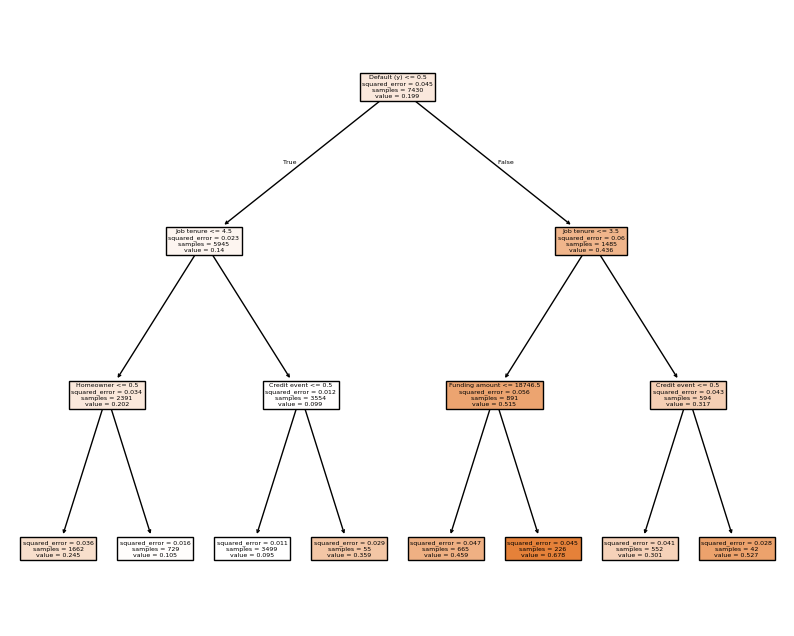

In [56]:
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(10,8))
plot_tree(tree_model, feature_names=X.columns, filled=True)
plt.show()

## Step 2: Estimate your own black-box machine learning model forecasting default. Each model is specific to a group of students and cannot be developed in collaboration with another group.

In [57]:
X = df.drop(columns=['PD','Pred_default (y_hat)','Group', 'Default (y)'])
y = df['Default (y)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalise data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# defining the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

# optimisation of hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# fit the model to the best hyperparameters
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300}
Accuracy: 0.8209959623149394
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1205
           1       0.65      0.12      0.20       281

    accuracy                           0.82      1486
   macro avg       0.74      0.55      0.55      1486
weighted avg       0.79      0.82      0.77      1486



## Step 3: Analyze the forecasting performance of your own model.

In [58]:
# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Best params: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

# Feature importance
feature_importance = best_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)
for idx in sorted_idx[-10:]:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")

Best params: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300}
Accuracy: 0.8210
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1205
           1       0.65      0.12      0.20       281

    accuracy                           0.82      1486
   macro avg       0.74      0.55      0.55      1486
weighted avg       0.79      0.82      0.77      1486

Confusion Matrix:
[[1187   18]
 [ 248   33]]
Monthly payment: 0.0442
Car price: 0.0498
Age: 0.0535
Down payment: 0.0634
Funding amount: 0.0665
Credit event: 0.0687
Loan duration: 0.0825
Married: 0.0973
Homeowner: 0.2226
Job tenure: 0.2294


The low MSE indicates that, on average, the model's predictions deviate by about (√0.0056) from the actual values. The high R2 score shows that the model explains approximately 87.27% of the variance in the data, it means that it captures quite well the majority of the trends.

## Step 4: Global interpretability: Implement one or two surrogate model(s) to interpret your own model. Compare the results provided in Steps 1 and 4.

Reliability of decision tree as a surrogate model (R2): 0.8223357074377655


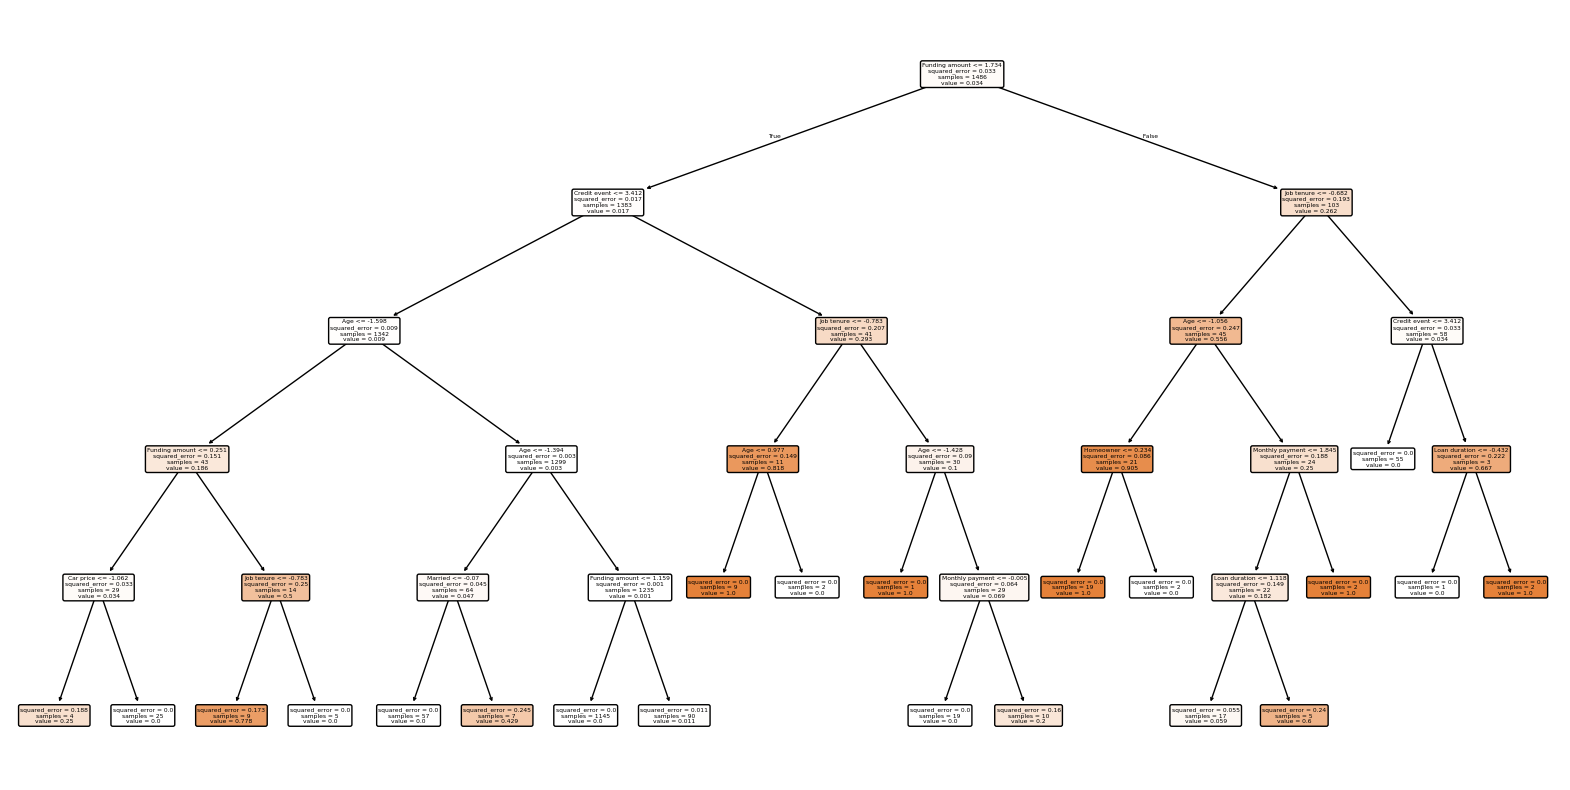


 Feature importance for decision tree:
            feature  importance
1        Job tenure    0.320399
2               Age    0.217245
4    Funding amount    0.192599
8      Credit event    0.110306
10        Homeowner    0.044680
6     Loan duration    0.044401
7   Monthly payment    0.036774
9           Married    0.028274
3         Car price    0.005321
0                ID    0.000000


In [59]:
# Predict the xgb model
y_pred_xgb = best_model.predict(X_test_scaled)

# decision tree as surrogate model
dt_surrogate = DecisionTreeRegressor(max_depth=5)
dt_surrogate.fit(X_test_scaled, y_pred_xgb)

dt_fidelity = r2_score(y_pred_xgb, dt_surrogate.predict(X_test_scaled))

print("Reliability of decision tree as a surrogate model (R2):", dt_fidelity)


plt.figure(figsize=(20,10))
plot_tree(dt_surrogate, feature_names=X.columns, filled=True, rounded=True)
plt.show()

# feature importance 
dt_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_surrogate.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Feature importance for decision tree:")
print(dt_feature_importance.head(10))

## Step 5: Global interpretability: Implement the PDP method to interpret your own model. Compare the results provided in Steps 4 and 5.

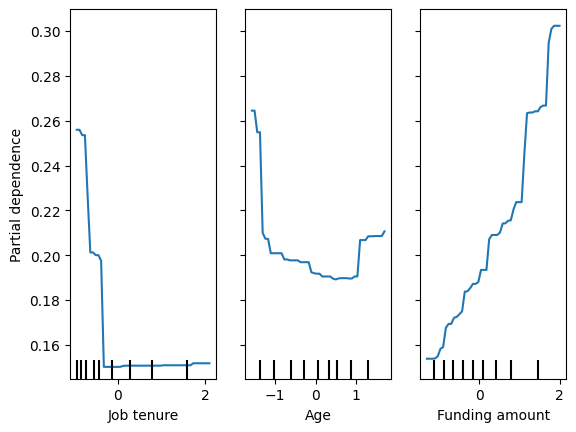

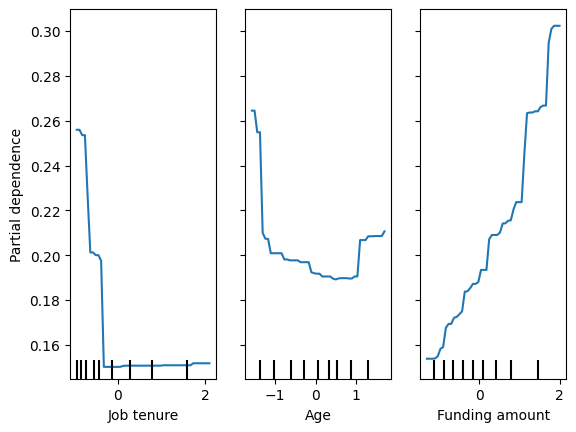

In [61]:
# PDP for XGBoost model
features = [1, 2, 4]  

pd_results = PartialDependenceDisplay.from_estimator(best_model, X_train_scaled, features, feature_names=X.columns, grid_resolution=50)

pd_results.plot()
plt.subplots_adjust(hspace=0.3)
plt.show()

The curve is linear, thus it indicates a linear relationship between these 3 features and the prediction.

## Step 6: Local interpretability: Implement the ICE method to interpret your own model.

Top feature indices: [1, 10, 9]


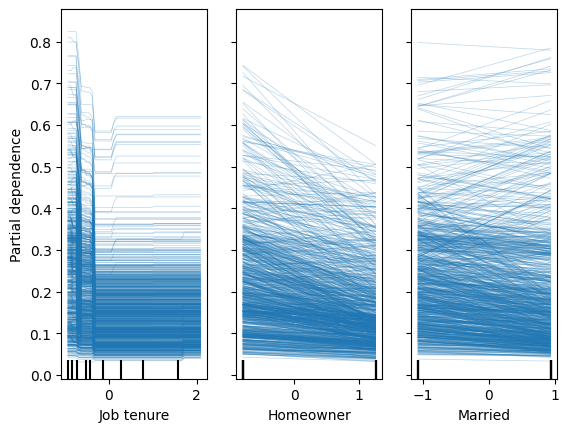

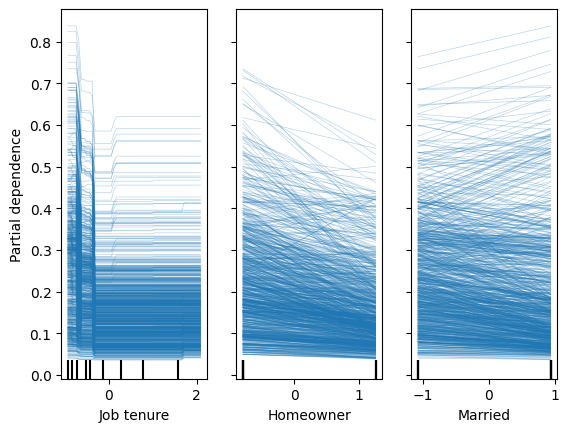

In [62]:
# feature importance of xgboost model
feature_importances = best_model.feature_importances_

feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

top_features = feature_importance_xgb.head(3)['feature'].tolist()
top_feature_indices = [X.columns.get_loc(feature) for feature in top_features]

print("Top feature indices:", top_feature_indices)

# Compute the ICE for the top features
ice_results = PartialDependenceDisplay.from_estimator(best_model, X_train_scaled, top_feature_indices, feature_names=X.columns, grid_resolution=50, kind='individual')

ice_results.plot()
plt.subplots_adjust(hspace=0.3)
plt.show()

## Step 7: Local interpretability: Implement the SHAP method to interpret your own model. Compare the results provided in Steps 6 and 7.

## Step 8: Performance interpretability: Implement the permutation importance method and/or the XPER method to identify the main drivers of the predictive performance of your model. Are the drivers of the performance metric (Step 8) similar to the drivers of the individual forecasts identified by SHAP (Step 7).

## Step 9: Assess the fairness of your own model with respect to age (protected attribute). Use a statistical test for the following three fairness definitions: Statistical Parity and Conditional Statistical Parity (groups are given in the dataset). Discuss your results.

## Step 10: Implement a FPDP using a fairness measure. Discuss your results.